Simulação aplicando diferentes metodos para a filtragem do ruído, no código abaixo simulamos o sinal base com PPC pontos por oscilação e tendo um comprimento de N pontos.

In [1]:
from pylab import *
#import numpy as np
#import matplotlib.pyplot as plt
#from numpy.fft import fft  # Importa fft


In [2]:
def geraSinal(amp, fase, PPC, NC):
    """ retorna o sinal x
           amplitude amp
           fase fase
           pontos por ciclo PPC
           número de ciclos NC
    """
    f = 1 # frequencia do sinal 1Hz
    Fs = f * PPC # Taxa de amostragem
    w = f / Fs   # frequencia digital
    N = NC * PPC # numero total de pontos (tempo total da simulação)
    n = np.arange(N)   # eixo n (tempo)
    # Sinal de entrada sem ruído
    x = amp * cos(2 * pi * w * n + fase)   # sinal de entrada
    return x


In [3]:
# Parâmetros da simulação
PPC =16 # pontos por ciclo
NC = 10  #  numero de ciclos completos
N = NC * PPC # numero total de pontos (tempo total da simulação)
f = 1 # frequencia do sinal 1Hz
Fs = f * PPC # Taxa de amostragem
w = f / Fs   # frequencia digital

amp = 1 # amplitude do sinal de teste
fase = pi/4  # fase fo sinal de teste
Z = amp*exp(1j*fase)
print(f'Z={Z:.2f}     real:{real(Z):.2f}  imag:{imag(Z):.2f}     abs:{abs(Z)}  fase:{angle(Z):.2f}')
x=geraSinal(amp,fase, PPC, NC)
n = np.arange(N)   # eixo n (tempo)

Z=0.71+0.71j     real:0.71  imag:0.71     abs:1.0  fase:0.79


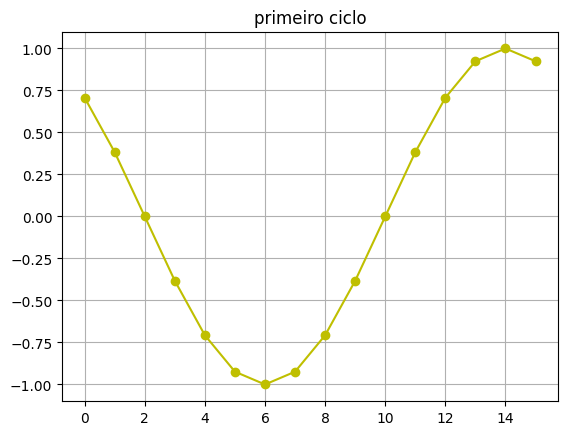

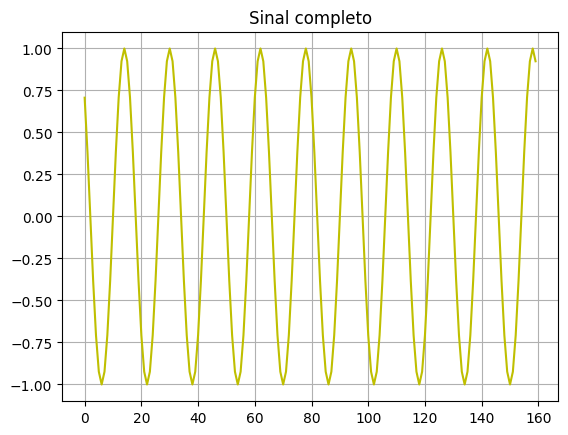

In [4]:
# Plotando o grafico

#primeiro 1 ciclo
plt.plot(range(PPC), x[0:PPC],"o-", color='y')
plt.title("primeiro ciclo")
plt.grid(True)
plt.show()

#sinal completo
plt.plot(n, x,"-", color='y')
plt.title("Sinal completo")
plt.grid(True)
plt.show()

In [5]:
#funções referentes as simulações
def LIAN(x, f, Fs):

    # Amostragem
    Sratio = Fs / (4 * f)
    o = arange(len(x) / Sratio) * Sratio
    o = o.astype(int)  # Garante que os índices sejam inteiros

    # Amostras In-phase e Quadratura
    oI, oQ = o[::2], o[1::2]

    # Processamento dos ciclos
    VI = (x[oI[:-1:2]] - x[oI[1::2]]) / 2
    VQ = -(x[oQ[:-1:2]] - x[oQ[1::2]]) / 2

    # Resultado complexo médio
    Y = mean(VI) + 1j * mean(VQ)

    return Y


def LIAF(x, f, Fs):
    """
    Lock-in amplifier via método DFT/FFT.
    """
    N = len(x)
    X = fft(x) / N
    bin = int(N * f / Fs)
    Y = 2 * X[bin]
    return Y


In [6]:
# simula varias vezes, obtendo varios tipos de medias (RMSE: complexo, real, imag, mag, fase)

T =1000
simulFunctions = [LIAN, LIAF]
ruidos = array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
#referencia = array([abs(Z), abs(real(Z)), abs(imag(Z)), abs(Z), 1])  # se fase = 0 ou pi/2 zera real ou imag.
referencia = array([abs(Z), abs(Z), abs(Z), abs(Z), 1]) # usar por enquanto normalizacao pelo valor abs(Z)
print(f'Referência:{referencia}')

def repeatSimulations(T,simulFunctions, ruidos):
    errosRuido=[]
    for ruido in ruidos:
        ASEL = [[0]*5]*len(simulFunctions) # lista para acumular erros quadraticos (Squared Errors)
        for _ in range(T):
            r = np.random.normal(0, ruido, N)
            xr = x + r
            for s,simFun in enumerate(simulFunctions):
                Y=simFun(xr, f, Fs)
                E = Z - Y   # erro = diferença entre o valor original (Z) e o valor estimado (Y) complexo.
                #EL = [E, real(E), imag(E), abs(E), angle(E)] # Lista de erros
                EL = [E, real(E), imag(E), abs(E), angle(Z)-angle(Y)] # numericamente mais estavel, calcula a diferenca dos angulos
                SEL = [q**2 for q in EL] # lista de erros quadraticos (Squared Error List)
                ASEL[s] = [q+w for q,w in zip(ASEL[s],SEL)] # acumula os erros quadraticos
        RMSEL = sqrt(array(ASEL)/T)/referencia  # Root Mean Square Error List
        errosRuido.append(RMSEL)  # para cada nivel de ruído
    return array(errosRuido)  # array 2D : nivel ruido x tipo erro (complex, real, imag, abs, angle)

e=repeatSimulations(T,simulFunctions,ruidos)


Referência:[1. 1. 1. 1. 1.]


Sinal amplitude:1  fase:45 graus  PPC:16  NC:10  N:160
Médias: 1000


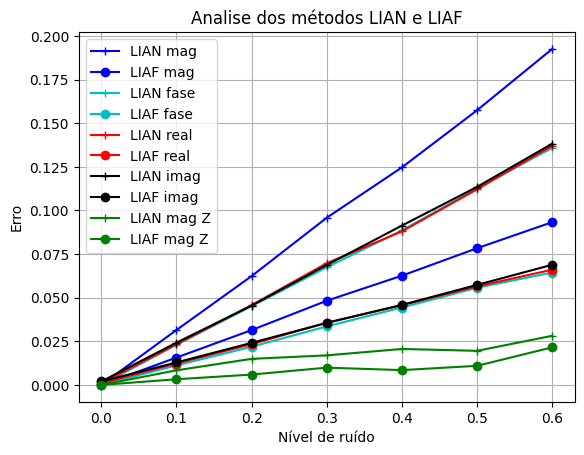

In [7]:
# Plotagem

print(f'Sinal amplitude:{amp}  fase:{fase*180/pi:.0f} graus  PPC:{PPC}  NC:{NC}  N:{N}')
print(f'Médias: {T}')

rsd = ruidos
# magnitude
plt.plot(rsd, real(e[:, 0, 3]), 'b-+', label='LIAN mag')
plt.plot(rsd, real(e[:,1, 3]), 'b-o', label='LIAF mag')

# # fase
plt.plot(rsd, abs(e[:, 0, 4]), 'c-+', label='LIAN fase')
plt.plot(rsd, abs(e[:, 1, 4]), 'c-o', label='LIAF fase ')

# real
plt.plot(rsd, abs(e[:, 0, 1])+0.001, 'r-+', label='LIAN real')
plt.plot(rsd, abs(e[:, 1, 1])+0.001, 'r-o', label='LIAF real ')

# imag
plt.plot(rsd, abs(e[:, 0, 2])+0.002, 'k-+', label='LIAN imag')
plt.plot(rsd, abs(e[:, 1, 2])+0.002, 'k-o', label='LIAF imag ')

#mag complex
plt.plot(rsd, abs(e[:, 0, 0]), 'g-+', label='LIAN mag Z')
plt.plot(rsd, abs(e[:, 1, 0]), 'g-o', label='LIAF mag Z')

plt.xlabel('Nível de ruído')
plt.ylabel('Erro')
plt.legend()
plt.title("Analise dos métodos LIAN e LIAF")
plt.grid(True)
plt.show()


A forma de calcular o erro (RMSE) é praticamente equivalente (RMSE real = imag = fase). O RMSE magnitude fica um pouco mais elevado, e o magnitidu do valor complexo fica reduzido.<br>
Podemos seguir com o RMSE magnitude para as análises.

In [8]:
# simula T vezes, obtendo RMSE (mag) em função do ruido
T =1000
simulFunctions = [LIAN, LIAF]
ruidos = array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
referencia = array([abs(Z), 1])

def repeatSimulations(T,simulFunctions, ruidos):
    errosRuido=[]
    for ruido in ruidos:
        RMSEL = [[0]*5]*len(simulFunctions)  # lista de zeros. Não elegante ! mudar para array: zeros()
        for _ in range(T):
            r = np.random.normal(0, ruido, N)
            xr = x + r
            for s,simFun in enumerate(simulFunctions):
                Y=simFun(xr, f, Fs)
                E = Z - Y
                EL = [abs(E)]
                EL = [q**2 for q in EL]
                RMSEL[s] = [q+w for q,w in zip(RMSEL[s],EL)]
        RMSEL = sqrt(array(RMSEL)/T)/referencia
        errosRuido.append(RMSEL)
    return array(errosRuido)

e=repeatSimulations(T,simulFunctions,ruidos)


Sinal amplitude:1  fase:45 graus  PPC:16  NC:10  N:160
Médias: 1000


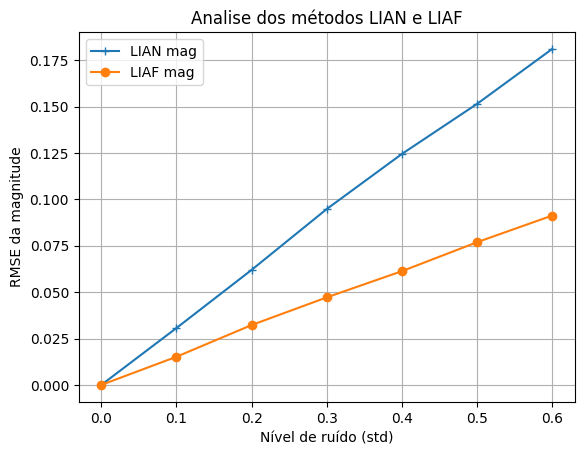

In [9]:
# Plotagem erro x ruido

print(f'Sinal amplitude:{amp}  fase:{fase*180/pi:.0f} graus  PPC:{PPC}  NC:{NC}  N:{N}')
print(f'Médias: {T}')
rsd = ruidos
#mag
plot(rsd, abs(e[:, 0, 0]), '-+', label='LIAN mag')
plot(rsd, abs(e[:, 1, 0]), '-o', label='LIAF mag')

plt.xlabel('Nível de ruído (std)')
plt.ylabel('RMSE da magnitude')
plt.legend()
plt.title("Analise dos métodos LIAN e LIAF")
plt.grid(True)
plt.show()


Comentário: LIA-Fourier consegue ser mais robusto que LIA-Nyquist no aumento de ruído

In [10]:
# simula T vezes, obtendo RMSE (mag) em função do ruido para diferentes PPC

T =1000
simulFunctions = [LIAN, LIAF]
ruidos = array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
PPCs=[4, 8, 16, 32]
referencia = array([abs(Z), abs(Z), abs(Z), abs(Z), 1])

def repeatSimulations(T,simulFunctions, ruidos, PPCs):
    errosRuido=[]
    for ruido in ruidos:
        #ASEL = [[[0]*1]*len(simulFunctions)]*len(PPCs) # lista de acumulacao de erros quadraticos
        ASEL = zeros((len(PPCs), len(simulFunctions), 1))
        for _ in range(T):
            for p, ppc in enumerate(PPCs):
                x = geraSinal(amp, fase, ppc, NC)
                r = np.random.normal(0, ruido, ppc*NC)
                xr = x + r
                for s,simFun in enumerate(simulFunctions):
                    Y=simFun(xr, f, ppc*f)
                    E = Z - Y
                    SE = abs(E)**2
                    ASEL[p][s][0] = ASEL[p][s][0]+SE
        RMSEL = sqrt(ASEL/T)
        errosRuido.append(RMSEL)
    return array(errosRuido)

e=repeatSimulations(T,simulFunctions,ruidos, PPCs)

In [11]:
print(shape(e))
print('(ruido, PPC, LIA, erro)')
#print(e)

(7, 4, 2, 1)
(ruido, PPC, LIA, erro)


Sinal amplitude:1  fase:45 graus  PPC:[4, 8, 16, 32]  NC:10  N:[ 40  80 160 320]
Médias: 1000


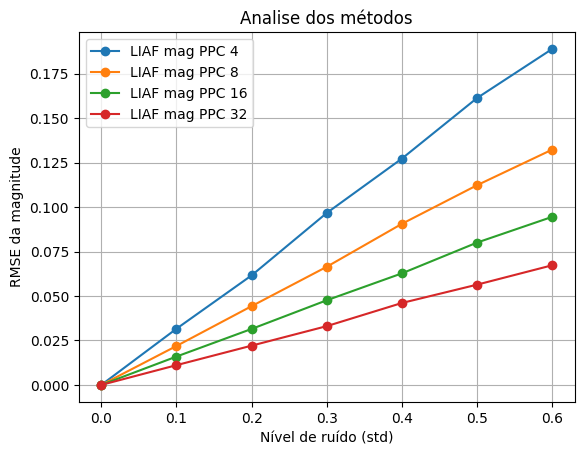

In [14]:
# Plotagem do erro x ruído para diferentes PPCs

print(f'Sinal amplitude:{amp}  fase:{fase*180/pi:.0f} graus  PPC:{PPCs}  NC:{NC}  N:{array(PPCs)*NC}')
print(f'Médias: {T}')

rsd = ruidos

for p,ppc in enumerate(PPCs):
    plot(rsd, abs(e[:, p, 0, 0]), '-+', label=f'LIAN mag PPC {ppc}')
    plot(rsd, abs(e[:, p, 1, 0]), '-o', label=f'LIAF mag PPC {ppc}')


xlabel('Nível de ruído (std)')
ylabel('RMSE da magnitude')
legend()
title("Analise dos métodos")
grid(True)
show()

Comentário: O LIA-Nyquist não varia com pontos por ciclo pois são sempre 4 PPC. Já o LIA-Fourier vai ficando mais reduzindo o erro com mais PPC. QUando PPC=4 os dois se equivalem (pode-se mostrar analiticamente isto).

Abaixo fazemos a simulação usando o mesmo sinal, a diferença seria na variação de T que simula o sinal T vezes e tira a média dos valores obtidos, o que significa que quanto maior o T mais estável será o erro.

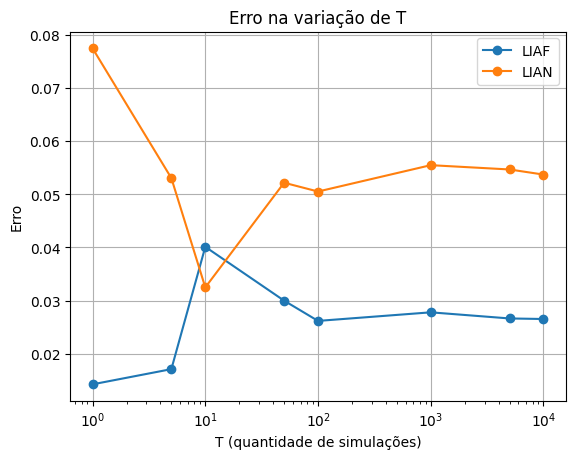

In [13]:
#Array com os T (quantidade de simulações) desejados
T_array = ([1, 5, 10, 50, 100, 1000, 5000, 10000])
eamt = []

for tcp in T_array:
    Erro_T = []
    for _ in range(tcp):

        # gerando um ruido e um sinal novo a cada simulação
        r_4 = np.random.normal(0, 0.3, N)
        xr_4 = amp * cos(2 * np.pi * w * n ) + r_4

        # Aplicando as  funções
        yn_4 = LIAN(xr_4, f, Fs)
        yf_4 = LIAF(xr_4, f, Fs)

        # Calcula o erro absoluto para cada método e armazena como tupla
        Erro_T.append([abs(abs(yn_4) - amp), abs(abs(yf_4) - amp)])

    eamt.append(np.mean(Erro_T, axis=0))

# convertendo para erro relativo
et = array(eamt) / amp

# plotando
plt.semilogx(T_array, et[:, 1], '-o', label='LIAF')
plt.semilogx(T_array, et[:, 0], '-o', label='LIAN')

plt.xlabel('T (quantidade de simulações)')
plt.ylabel('Erro')
plt.legend()
plt.title("Erro na variação de T")
plt.grid(True)
plt.show()

Comentário: QUando T>10²=100 já notamos uma estabilidade dos valores.